In [31]:
%run 'basic_functions.ipynb'


In [32]:
def plot_cv_results_comparison_by_dataset(json_file='cv_results.json'):
    """
    Create comparison charts from CV results JSON file with datasets on x-axis.
    Shows datasets vs methods with mean scores and standard deviations.
    Calculates both MAPE and RMSE from fold results automatically.
    """
    
    # Read the JSON file
    try:
        with open(json_file, 'r') as f:
            cv_data = json.load(f)
    except FileNotFoundError:
        print(f"❌ File {json_file} not found!")
        return
    
    # Parse data and calculate metrics from fold results
    results_data = []
    
    def calculate_mape(actual, predictions):
        """Calculate MAPE, handling zero values"""
        actual = np.array(actual)
        predictions = np.array(predictions)
        mask = actual != 0
        if mask.any():
            return np.mean(np.abs((actual[mask] - predictions[mask]) / actual[mask])) * 100
        else:
            return np.inf
    
    def calculate_rmse(actual, predictions):
        """Calculate RMSE"""
        actual = np.array(actual)
        predictions = np.array(predictions)
        return np.sqrt(np.mean((actual - predictions) ** 2))
    
    for method_name, datasets_list in cv_data.items():
        for dataset_info in datasets_list:
            fold_results = dataset_info.get('fold_results', [])
            
            # Calculate MAPE and RMSE for each fold
            mape_scores = []
            rmse_scores = []
            
            for fold_data in fold_results:
                actual = fold_data['actual']
                predictions = fold_data['predictions']
                
                # Calculate metrics for this fold
                mape_score = calculate_mape(actual, predictions)
                rmse_score = calculate_rmse(actual, predictions)
                
                if np.isfinite(mape_score):
                    mape_scores.append(mape_score)
                if np.isfinite(rmse_score):
                    rmse_scores.append(rmse_score)
            
            # Add MAPE results
            if mape_scores:
                results_data.append({
                    'method': method_name,
                    'dataset': dataset_info['dataset_name'],
                    'metric': 'mape',
                    'mean_score': np.mean(mape_scores),
                    'std_score': np.std(mape_scores),
                    'n_splits': len(mape_scores)
                })
            
            # Add RMSE results
            if rmse_scores:
                results_data.append({
                    'method': method_name,
                    'dataset': dataset_info['dataset_name'],
                    'metric': 'rmse',
                    'mean_score': np.mean(rmse_scores),
                    'std_score': np.std(rmse_scores),
                    'n_splits': len(rmse_scores)
                })
    
    df = pd.DataFrame(results_data)
    
    # Separate MAPE and RMSE data
    mape_data = df[df['metric'] == 'mape'].copy()
    rmse_data = df[df['metric'] == 'rmse'].copy()
    
    print(f"📊 Found {len(df)} total experiments:")
    print(f"   - MAPE experiments: {len(mape_data)}")
    print(f"   - RMSE experiments: {len(rmse_data)}")
    print(f"   - Methods: {list(df['method'].unique())}")
    print(f"   - Datasets: {list(df['dataset'].unique())}")
    
    # Colors for different methods
    methods = df['method'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
    method_colors = dict(zip(methods, colors))
    
    # MAPE Plot
    if len(mape_data) > 0:
        plt.figure(figsize=(16, 8))
        datasets = mape_data['dataset'].unique()
        
        x_pos = np.arange(len(datasets))
        bar_width = 0.8 / len(methods) if len(methods) > 0 else 0.8
        
        for i, method in enumerate(methods):
            method_mape = mape_data[mape_data['method'] == method]
            if len(method_mape) == 0:
                continue
                
            # Get scores for each dataset (fill missing with NaN)
            scores = []
            errors = []
            for dataset in datasets:
                dataset_data = method_mape[method_mape['dataset'] == dataset]
                if len(dataset_data) > 0:
                    scores.append(dataset_data['mean_score'].iloc[0])
                    errors.append(dataset_data['std_score'].iloc[0])
                else:
                    scores.append(np.nan)
                    errors.append(0)
            
            # Remove NaN values for plotting
            valid_indices = ~np.isnan(scores)
            if valid_indices.any():
                x_positions = x_pos[valid_indices] + i * bar_width
                valid_scores = np.array(scores)[valid_indices]
                valid_errors = np.array(errors)[valid_indices]
                
                plt.bar(x_positions, valid_scores, bar_width, 
                       yerr=valid_errors, capsize=5,
                       label=method, color=method_colors[method], 
                       alpha=0.8, edgecolor='black', linewidth=0.5)
        
        plt.xlabel('Datasets', fontsize=12, fontweight='bold')
        plt.ylabel('MAPE (%)', fontsize=12, fontweight='bold')
        plt.title('MAPE Comparison: Datasets vs Methods', fontsize=14, fontweight='bold')
        plt.xticks(x_pos + bar_width * (len(methods) - 1) / 2, datasets, rotation=45, ha='right')
        plt.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(16, 8))
        plt.text(0.5, 0.5, 'No MAPE data available', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=16)
        plt.title('MAPE Comparison', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # RMSE Plot
    if len(rmse_data) > 0:
        plt.figure(figsize=(16, 8))
        datasets = rmse_data['dataset'].unique()
        
        x_pos = np.arange(len(datasets))
        bar_width = 0.8 / len(methods) if len(methods) > 0 else 0.8
        
        for i, method in enumerate(methods):
            method_rmse = rmse_data[rmse_data['method'] == method]
            if len(method_rmse) == 0:
                continue
                
            # Get scores for each dataset (fill missing with NaN)
            scores = []
            errors = []
            for dataset in datasets:
                dataset_data = method_rmse[method_rmse['dataset'] == dataset]
                if len(dataset_data) > 0:
                    scores.append(dataset_data['mean_score'].iloc[0])
                    errors.append(dataset_data['std_score'].iloc[0])
                else:
                    scores.append(np.nan)
                    errors.append(0)
            
            # Remove NaN values for plotting
            valid_indices = ~np.isnan(scores)
            if valid_indices.any():
                x_positions = x_pos[valid_indices] + i * bar_width
                valid_scores = np.array(scores)[valid_indices]
                valid_errors = np.array(errors)[valid_indices]
                
                plt.bar(x_positions, valid_scores, bar_width, 
                       yerr=valid_errors, capsize=5,
                       label=method, color=method_colors[method], 
                       alpha=0.8, edgecolor='black', linewidth=0.5)
        
        plt.xlabel('Datasets', fontsize=12, fontweight='bold')
        plt.ylabel('RMSE', fontsize=12, fontweight='bold')
        plt.title('RMSE Comparison: Datasets vs Methods', fontsize=14, fontweight='bold')
        plt.xticks(x_pos + bar_width * (len(methods) - 1) / 2, datasets, rotation=45, ha='right')
        plt.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(16, 8))
        plt.text(0.5, 0.5, 'No RMSE data available', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=16)
        plt.title('RMSE Comparison', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # Print detailed results table
    print("\n" + "="*80)
    print("📈 DETAILED RESULTS SUMMARY (BY DATASET)")
    print("="*80)
    
    if len(mape_data) > 0:
        print("\n🎯 MAPE Results:")
        for dataset in datasets:
            print(f"\n  📊 {dataset}:")
            dataset_mape = mape_data[mape_data['dataset'] == dataset]
            for method in methods:
                method_data = dataset_mape[dataset_mape['method'] == method]
                if len(method_data) > 0:
                    mean_val = method_data['mean_score'].iloc[0]
                    std_val = method_data['std_score'].iloc[0]
                    print(f"    └─ {method}: {mean_val:.2f}% ± {std_val:.2f}%")
    
    if len(rmse_data) > 0:
        print("\n📏 RMSE Results:")
        for dataset in datasets:
            print(f"\n  📊 {dataset}:")
            dataset_rmse = rmse_data[rmse_data['dataset'] == dataset]
            for method in methods:
                method_data = dataset_rmse[dataset_rmse['method'] == method]
                if len(method_data) > 0:
                    mean_val = method_data['mean_score'].iloc[0]
                    std_val = method_data['std_score'].iloc[0]
                    print(f"    └─ {method}: {mean_val:.2f} ± {std_val:.2f}")
    
    return df


In [33]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path

def plot_cv_results_comparison(json_file='cv_results.json'):
    """
    Create comprehensive comparison charts from CV results JSON file.
    Shows methods vs datasets with mean scores and standard deviations.
    Calculates both MAPE and RMSE from fold results automatically.
    """
    
    # Read the JSON file
    try:
        with open(json_file, 'r') as f:
            cv_data = json.load(f)
    except FileNotFoundError:
        print(f"❌ File {json_file} not found!")
        return
    
    # Parse data and calculate metrics from fold results
    results_data = []
    
    def calculate_mape(actual, predictions):
        """Calculate MAPE, handling zero values"""
        actual = np.array(actual)
        predictions = np.array(predictions)
        mask = actual != 0
        if mask.any():
            return np.mean(np.abs((actual[mask] - predictions[mask]) / actual[mask])) * 100
        else:
            return np.inf
    
    def calculate_rmse(actual, predictions):
        """Calculate RMSE"""
        actual = np.array(actual)
        predictions = np.array(predictions)
        return np.sqrt(np.mean((actual - predictions) ** 2))
    
    for method_name, datasets_list in cv_data.items():
        for dataset_info in datasets_list:
            fold_results = dataset_info.get('fold_results', [])
            
            # Calculate MAPE and RMSE for each fold
            mape_scores = []
            rmse_scores = []
            
            for fold_data in fold_results:
                actual = fold_data['actual']
                predictions = fold_data['predictions']
                
                # Calculate metrics for this fold
                mape_score = calculate_mape(actual, predictions)
                rmse_score = calculate_rmse(actual, predictions)
                
                if np.isfinite(mape_score):
                    mape_scores.append(mape_score)
                if np.isfinite(rmse_score):
                    rmse_scores.append(rmse_score)
            
            # Add MAPE results
            if mape_scores:
                results_data.append({
                    'method': method_name,
                    'dataset': dataset_info['dataset_name'],
                    'metric': 'mape',
                    'mean_score': np.mean(mape_scores),
                    'std_score': np.std(mape_scores),
                    'n_splits': len(mape_scores)
                })
            
            # Add RMSE results
            if rmse_scores:
                results_data.append({
                    'method': method_name,
                    'dataset': dataset_info['dataset_name'],
                    'metric': 'rmse',
                    'mean_score': np.mean(rmse_scores),
                    'std_score': np.std(rmse_scores),
                    'n_splits': len(rmse_scores)
                })
    
    df = pd.DataFrame(results_data)
    
    # Separate MAPE and RMSE data
    mape_data = df[df['metric'] == 'mape'].copy()
    rmse_data = df[df['metric'] == 'rmse'].copy()
    
    print(f"📊 Found {len(df)} total experiments:")
    print(f"   - MAPE experiments: {len(mape_data)}")
    print(f"   - RMSE experiments: {len(rmse_data)}")
    print(f"   - Methods: {list(df['method'].unique())}")
    print(f"   - Datasets: {list(df['dataset'].unique())}")
    
    # Colors for different datasets
    datasets = df['dataset'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(datasets)))
    dataset_colors = dict(zip(datasets, colors))
    
    # MAPE Plot
    if len(mape_data) > 0:
        plt.figure(figsize=(16, 8))
        methods = mape_data['method'].unique()
        
        x_pos = np.arange(len(methods))
        bar_width = 0.8 / len(datasets) if len(datasets) > 0 else 0.8
        
        for i, dataset in enumerate(datasets):
            dataset_mape = mape_data[mape_data['dataset'] == dataset]
            if len(dataset_mape) == 0:
                continue
                
            # Get scores for each method (fill missing with NaN)
            scores = []
            errors = []
            for method in methods:
                method_data = dataset_mape[dataset_mape['method'] == method]
                if len(method_data) > 0:
                    scores.append(method_data['mean_score'].iloc[0])
                    errors.append(method_data['std_score'].iloc[0])
                else:
                    scores.append(np.nan)
                    errors.append(0)
            
            # Remove NaN values for plotting
            valid_indices = ~np.isnan(scores)
            if valid_indices.any():
                x_positions = x_pos[valid_indices] + i * bar_width
                valid_scores = np.array(scores)[valid_indices]
                valid_errors = np.array(errors)[valid_indices]
                
                plt.bar(x_positions, valid_scores, bar_width, 
                       yerr=valid_errors, capsize=5,
                       label=dataset, color=dataset_colors[dataset], 
                       alpha=0.8, edgecolor='black', linewidth=0.5)
        
        plt.xlabel('Methods', fontsize=12, fontweight='bold')
        plt.ylabel('MAPE (%)', fontsize=12, fontweight='bold')
        plt.title('MAPE Comparison: Methods vs Datasets', fontsize=14, fontweight='bold')
        plt.xticks(x_pos + bar_width * (len(datasets) - 1) / 2, methods, rotation=45, ha='right')
        plt.legend(title='Datasets', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(16, 8))
        plt.text(0.5, 0.5, 'No MAPE data available', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=16)
        plt.title('MAPE Comparison', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # RMSE Plot
    if len(rmse_data) > 0:
        plt.figure(figsize=(16, 8))
        methods = rmse_data['method'].unique()
        
        x_pos = np.arange(len(methods))
        bar_width = 0.8 / len(datasets) if len(datasets) > 0 else 0.8
        
        for i, dataset in enumerate(datasets):
            dataset_rmse = rmse_data[rmse_data['dataset'] == dataset]
            if len(dataset_rmse) == 0:
                continue
                
            # Get scores for each method (fill missing with NaN)
            scores = []
            errors = []
            for method in methods:
                method_data = dataset_rmse[dataset_rmse['method'] == method]
                if len(method_data) > 0:
                    scores.append(method_data['mean_score'].iloc[0])
                    errors.append(method_data['std_score'].iloc[0])
                else:
                    scores.append(np.nan)
                    errors.append(0)
            
            # Remove NaN values for plotting
            valid_indices = ~np.isnan(scores)
            if valid_indices.any():
                x_positions = x_pos[valid_indices] + i * bar_width
                valid_scores = np.array(scores)[valid_indices]
                valid_errors = np.array(errors)[valid_indices]
                
                plt.bar(x_positions, valid_scores, bar_width, 
                       yerr=valid_errors, capsize=5,
                       label=dataset, color=dataset_colors[dataset], 
                       alpha=0.8, edgecolor='black', linewidth=0.5)
        
        plt.xlabel('Methods', fontsize=12, fontweight='bold')
        plt.ylabel('RMSE', fontsize=12, fontweight='bold')
        plt.title('RMSE Comparison: Methods vs Datasets', fontsize=14, fontweight='bold')
        plt.xticks(x_pos + bar_width * (len(datasets) - 1) / 2, methods, rotation=45, ha='right')
        plt.legend(title='Datasets', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(16, 8))
        plt.text(0.5, 0.5, 'No RMSE data available', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=16)
        plt.title('RMSE Comparison', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # Print detailed results table
    print("\n" + "="*80)
    print("📈 DETAILED RESULTS SUMMARY")
    print("="*80)
    
    if len(mape_data) > 0:
        print("\n🎯 MAPE Results:")
        mape_pivot = mape_data.pivot(index='method', columns='dataset', values='mean_score')
        mape_std_pivot = mape_data.pivot(index='method', columns='dataset', values='std_score')
        
        for method in mape_pivot.index:
            print(f"\n  📊 {method}:")
            for dataset in mape_pivot.columns:
                mean_val = mape_pivot.loc[method, dataset]
                std_val = mape_std_pivot.loc[method, dataset]
                if not pd.isna(mean_val):
                    print(f"    └─ {dataset}: {mean_val:.2f}% ± {std_val:.2f}%")
    
    if len(rmse_data) > 0:
        print("\n📏 RMSE Results:")
        rmse_pivot = rmse_data.pivot(index='method', columns='dataset', values='mean_score')
        rmse_std_pivot = rmse_data.pivot(index='method', columns='dataset', values='std_score')
        
        for method in rmse_pivot.index:
            print(f"\n  📊 {method}:")
            for dataset in rmse_pivot.columns:
                mean_val = rmse_pivot.loc[method, dataset]
                std_val = rmse_std_pivot.loc[method, dataset]
                if not pd.isna(mean_val):
                    print(f"    └─ {dataset}: {mean_val:.2f} ± {std_val:.2f}")
    
    return df

def create_combined_comparison(json_file='cv_results.json'):
    """
    Create a single combined plot with both MAPE and RMSE, normalized for comparison.
    """
    try:
        with open(json_file, 'r') as f:
            cv_data = json.load(f)
    except FileNotFoundError:
        print(f"❌ File {json_file} not found!")
        return
    
    # Parse data
    results_data = []
    for method_name, datasets_list in cv_data.items():
        for dataset_info in datasets_list:
            results_data.append({
                'method': method_name,
                'dataset': dataset_info['dataset_name'],
                'metric': dataset_info['metric'],
                'mean_score': dataset_info['mean_score'],
                'std_score': dataset_info['std_score'],
            })
    
    df = pd.DataFrame(results_data)
    
    # Create a combined visualization
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    
    # Get unique combinations
    method_dataset_combos = df.groupby(['method', 'dataset']).size().reset_index().drop(columns=0)
    
    # Create positions for bars
    x_labels = []
    x_positions = []
    mape_values = []
    rmse_values = []
    mape_errors = []
    rmse_errors = []
    
    pos = 0
    for _, combo in method_dataset_combos.iterrows():
        method = combo['method']
        dataset = combo['dataset']
        
        # Get MAPE data
        mape_row = df[(df['method'] == method) & (df['dataset'] == dataset) & (df['metric'] == 'mape')]
        rmse_row = df[(df['method'] == method) & (df['dataset'] == dataset) & (df['metric'] == 'rmse')]
        
        if len(mape_row) > 0 or len(rmse_row) > 0:
            x_labels.append(f"{method}\n{dataset}")
            x_positions.append(pos)
            
            # MAPE values
            if len(mape_row) > 0:
                mape_values.append(mape_row['mean_score'].iloc[0])
                mape_errors.append(mape_row['std_score'].iloc[0])
            else:
                mape_values.append(0)
                mape_errors.append(0)
            
            # RMSE values (normalized by scaling)
            if len(rmse_row) > 0:
                rmse_values.append(rmse_row['mean_score'].iloc[0])
                rmse_errors.append(rmse_row['std_score'].iloc[0])
            else:
                rmse_values.append(0)
                rmse_errors.append(0)
            
            pos += 1
    
    # Create grouped bar chart
    bar_width = 0.35
    x_pos = np.arange(len(x_positions))
    
    # MAPE bars
    mape_bars = ax.bar(x_pos - bar_width/2, mape_values, bar_width, 
                      yerr=mape_errors, capsize=5, label='MAPE (%)', 
                      color='skyblue', alpha=0.8, edgecolor='black')
    
    # RMSE bars (on secondary y-axis)
    ax2 = ax.twinx()
    rmse_bars = ax2.bar(x_pos + bar_width/2, rmse_values, bar_width,
                       yerr=rmse_errors, capsize=5, label='RMSE', 
                       color='lightcoral', alpha=0.8, edgecolor='black')
    
    # Formatting
    ax.set_xlabel('Method - Dataset', fontsize=12, fontweight='bold')
    ax.set_ylabel('MAPE (%)', fontsize=12, fontweight='bold', color='blue')
    ax2.set_ylabel('RMSE', fontsize=12, fontweight='bold', color='red')
    ax.set_title('Cross-Validation Results: Methods vs Datasets', fontsize=14, fontweight='bold')
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    
    # Legends
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

# Usage examples:
print("🎯 CV Results Comparison Tool")
print("="*50)
print("Available functions:")
print("1. plot_cv_results_comparison() - Side-by-side MAPE and RMSE comparison")
print("2. create_combined_comparison() - Combined plot with dual y-axes")
print("\nRunning the main comparison...")

🎯 CV Results Comparison Tool
Available functions:
1. plot_cv_results_comparison() - Side-by-side MAPE and RMSE comparison
2. create_combined_comparison() - Combined plot with dual y-axes

Running the main comparison...


📊 Found 50 total experiments:
   - MAPE experiments: 25
   - RMSE experiments: 25
   - Methods: ['naive_seasonal', 'historical_mean', 'last_value', 'timesfm_forecast', 'moirai_forecast']
   - Datasets: ['australian_electricity_demand', 'egg_sales', 'saugeen_river', 'car_parts', 'wti_oil']


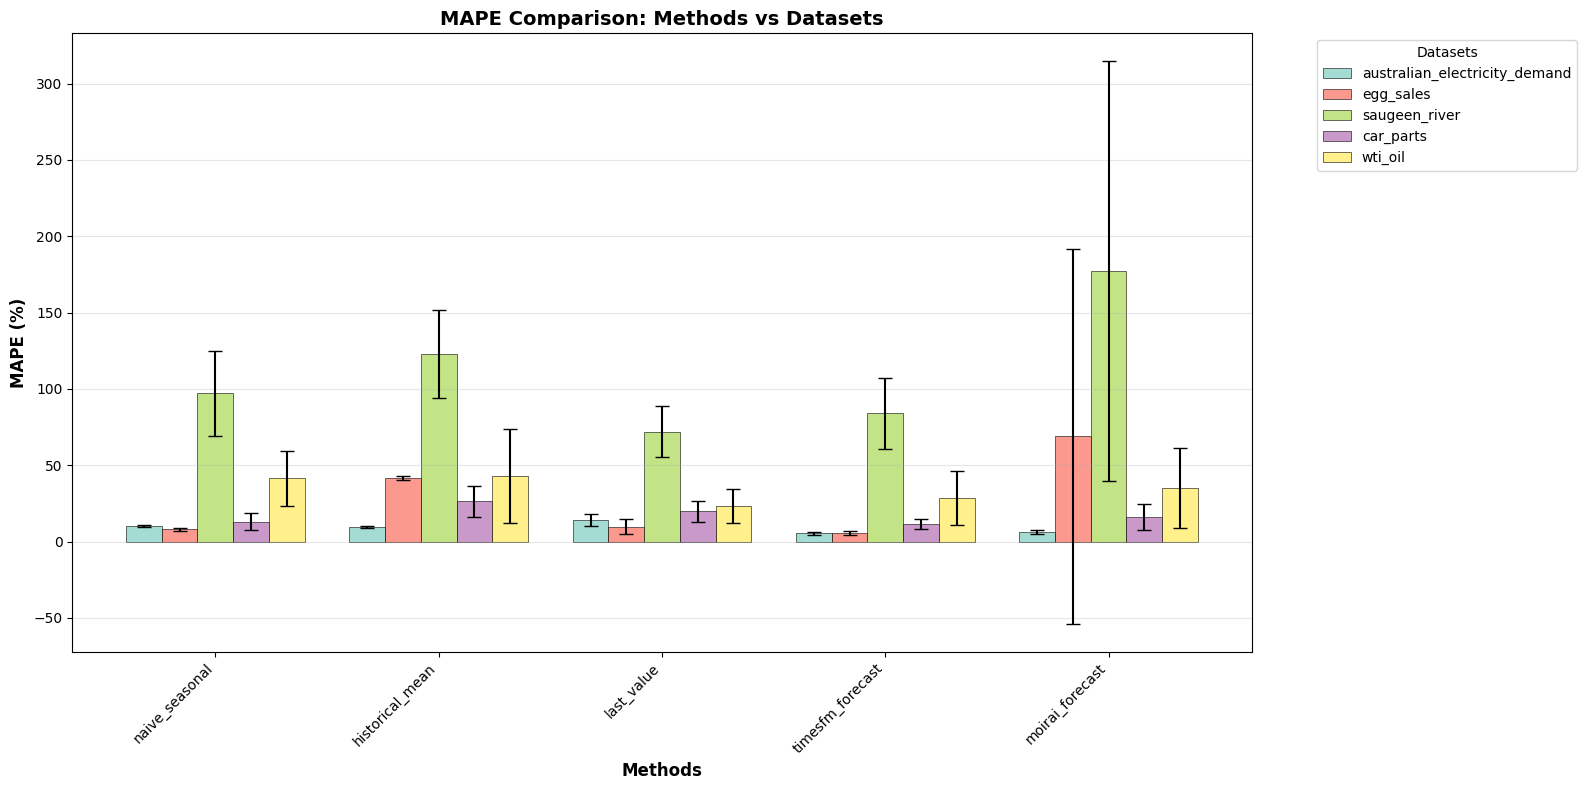

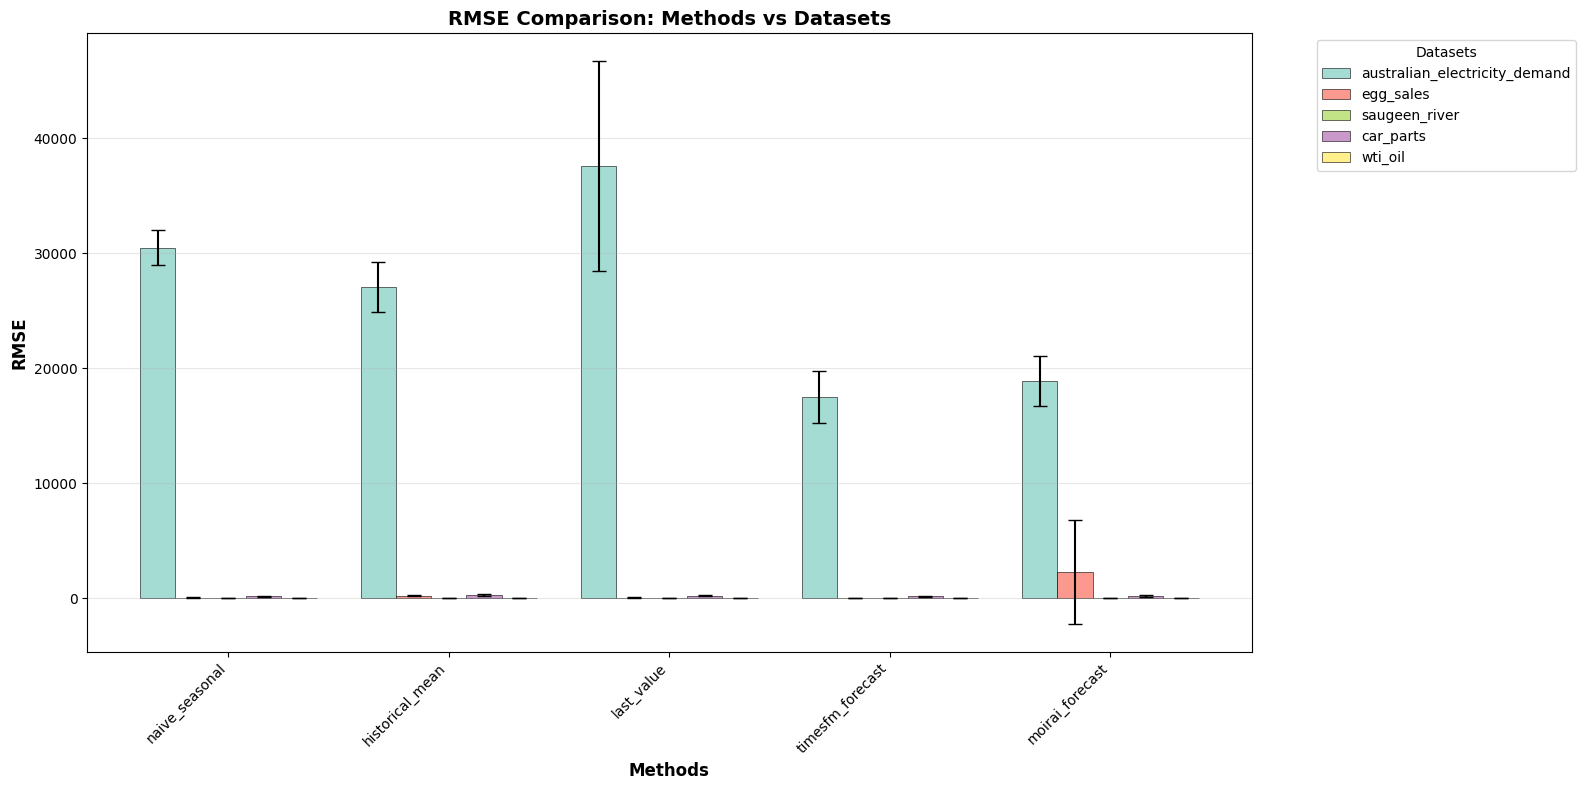


📈 DETAILED RESULTS SUMMARY

🎯 MAPE Results:

  📊 historical_mean:
    └─ australian_electricity_demand: 9.41% ± 0.60%
    └─ car_parts: 26.31% ± 10.02%
    └─ egg_sales: 41.94% ± 1.25%
    └─ saugeen_river: 122.94% ± 29.06%
    └─ wti_oil: 42.72% ± 30.78%

  📊 last_value:
    └─ australian_electricity_demand: 13.98% ± 3.81%
    └─ car_parts: 19.92% ± 6.82%
    └─ egg_sales: 9.81% ± 4.91%
    └─ saugeen_river: 72.14% ± 17.02%
    └─ wti_oil: 23.28% ± 11.29%

  📊 moirai_forecast:
    └─ australian_electricity_demand: 6.38% ± 1.16%
    └─ car_parts: 15.94% ± 8.57%
    └─ egg_sales: 69.09% ± 122.73%
    └─ saugeen_river: 177.20% ± 137.36%
    └─ wti_oil: 35.04% ± 26.13%

  📊 naive_seasonal:
    └─ australian_electricity_demand: 10.36% ± 0.54%
    └─ car_parts: 12.92% ± 5.57%
    └─ egg_sales: 8.04% ± 1.19%
    └─ saugeen_river: 97.26% ± 27.84%
    └─ wti_oil: 41.53% ± 17.99%

  📊 timesfm_forecast:
    └─ australian_electricity_demand: 5.35% ± 0.73%
    └─ car_parts: 11.49% ± 3.41%
    └─ 

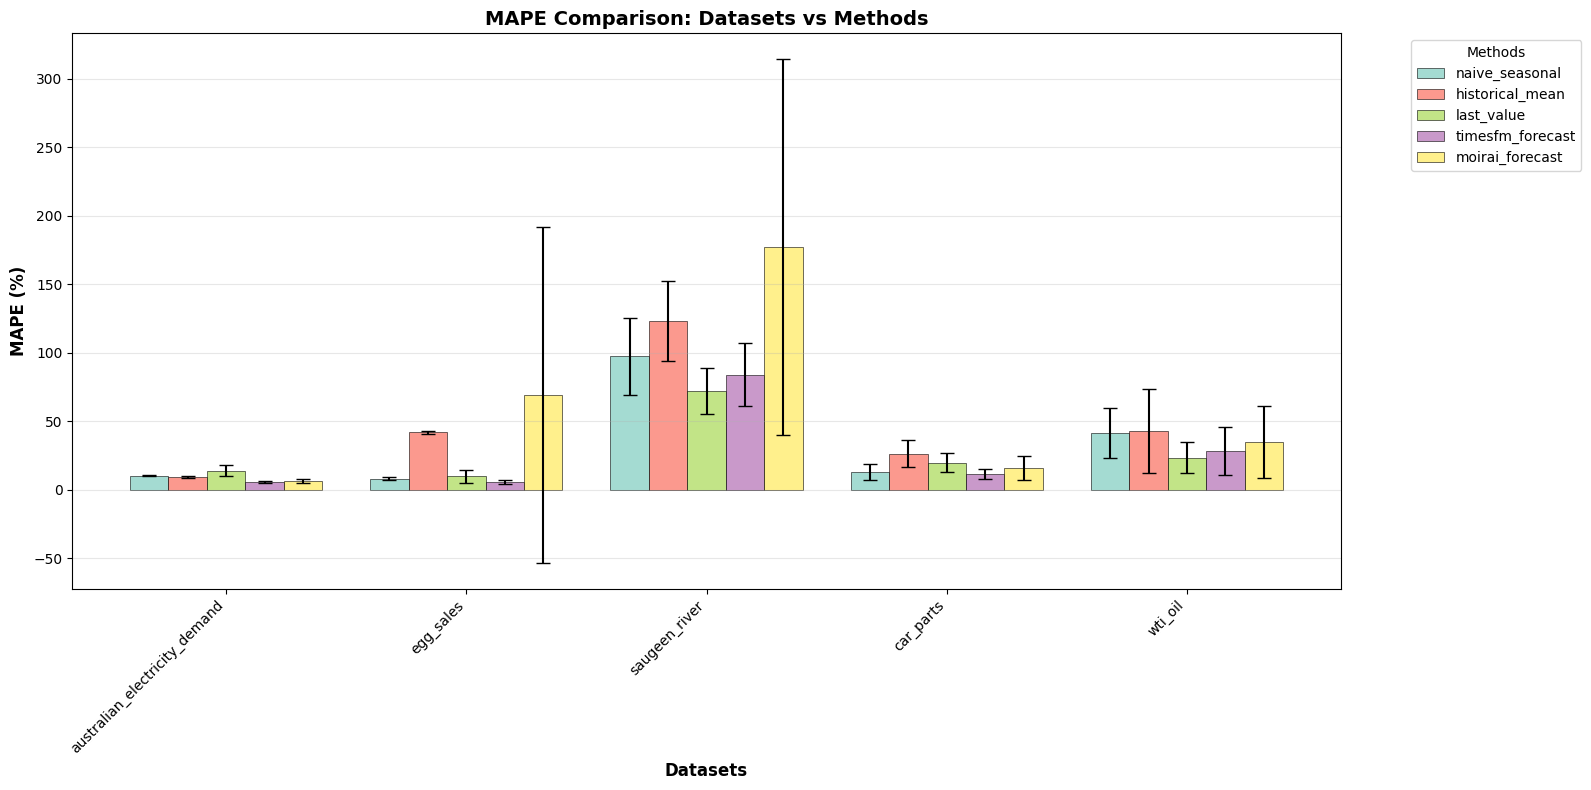

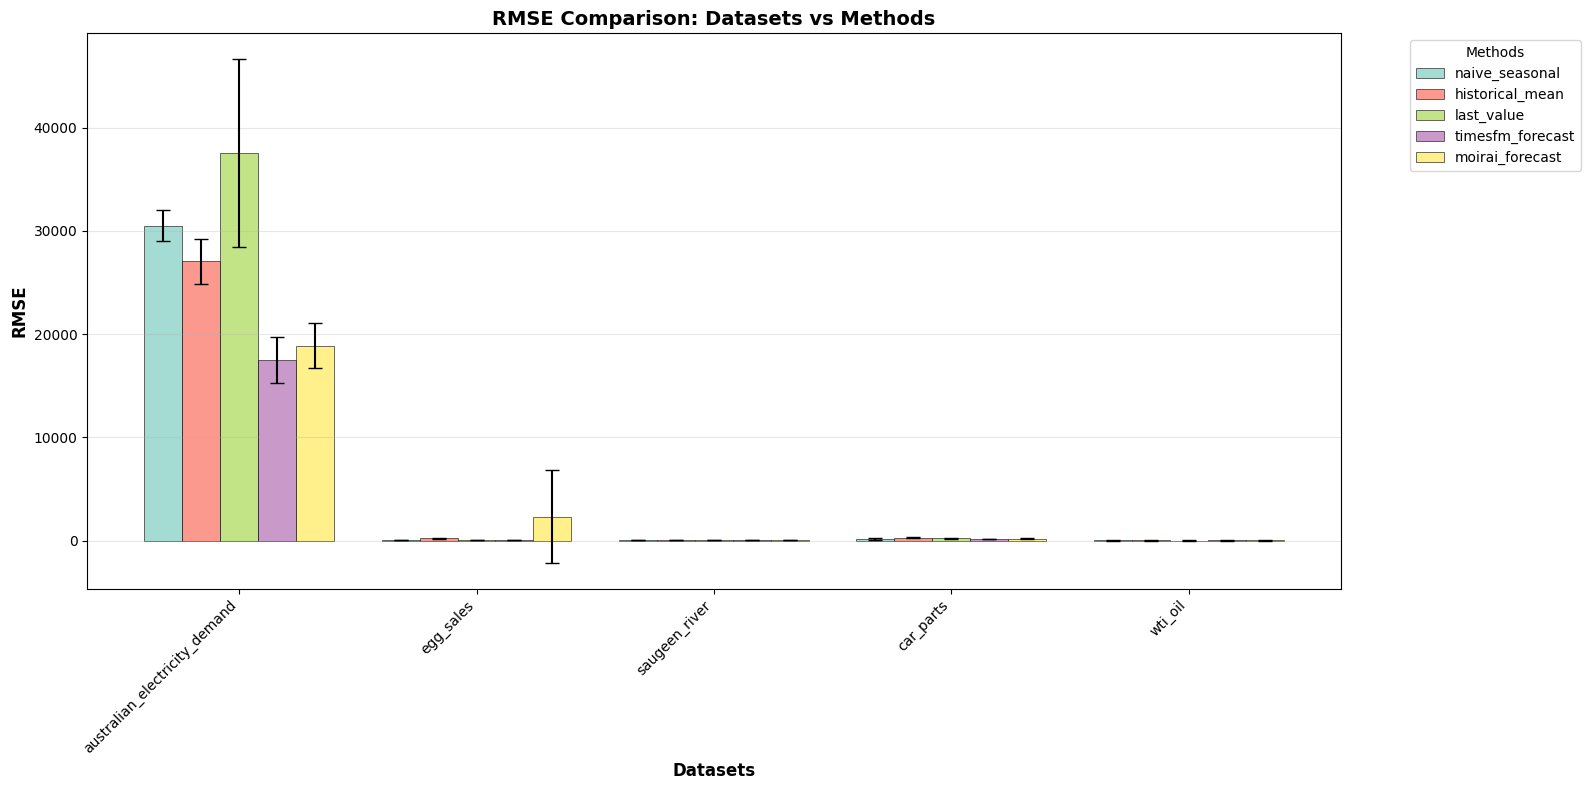


📈 DETAILED RESULTS SUMMARY (BY DATASET)

🎯 MAPE Results:

  📊 australian_electricity_demand:
    └─ naive_seasonal: 10.36% ± 0.54%
    └─ historical_mean: 9.41% ± 0.60%
    └─ last_value: 13.98% ± 3.81%
    └─ timesfm_forecast: 5.35% ± 0.73%
    └─ moirai_forecast: 6.38% ± 1.16%

  📊 egg_sales:
    └─ naive_seasonal: 8.04% ± 1.19%
    └─ historical_mean: 41.94% ± 1.25%
    └─ last_value: 9.81% ± 4.91%
    └─ timesfm_forecast: 5.66% ± 1.18%
    └─ moirai_forecast: 69.09% ± 122.73%

  📊 saugeen_river:
    └─ naive_seasonal: 97.26% ± 27.84%
    └─ historical_mean: 122.94% ± 29.06%
    └─ last_value: 72.14% ± 17.02%
    └─ timesfm_forecast: 84.11% ± 23.17%
    └─ moirai_forecast: 177.20% ± 137.36%

  📊 car_parts:
    └─ naive_seasonal: 12.92% ± 5.57%
    └─ historical_mean: 26.31% ± 10.02%
    └─ last_value: 19.92% ± 6.82%
    └─ timesfm_forecast: 11.49% ± 3.41%
    └─ moirai_forecast: 15.94% ± 8.57%

  📊 wti_oil:
    └─ naive_seasonal: 41.53% ± 17.99%
    └─ historical_mean: 42.72% ± 30.

,method,dataset,metric,mean_score,std_score,n_splits
0,naive_seasonal,australian_electricity_demand,mape,10.360578,0.536211,5
1,naive_seasonal,australian_electricity_demand,rmse,30485.581332,1508.573883,5
2,naive_seasonal,egg_sales,mape,8.039919,1.189691,5
3,naive_seasonal,egg_sales,rmse,56.398402,16.889040,5
4,naive_seasonal,saugeen_river,mape,97.264752,27.835620,5
5,naive_seasonal,saugeen_river,rmse,48.640775,8.536235,5
6,naive_seasonal,car_parts,mape,12.921431,5.574757,5
7,naive_seasonal,car_parts,rmse,157.888422,59.735803,5
8,naive_seasonal,wti_oil,mape,41.529051,17.986902,5
9,naive_seasonal,wti_oil,rmse,28.147699,12.274052,5


In [34]:
plot_cv_results_comparison()
plot_cv_results_comparison_by_dataset()